# Fine-tuning Transformer for Text Classification

這是一篇使用 Transformation 做中文文本分類的 Notebook，整個任務的流程可分為：

1. Data Preprocessing 
2. Modeling
3. Training
4. Evaluation

資料的部分使用 THUCNews 的一部分做為訓練與模型評估之用，原資料集一共有14個類別，這邊僅使用其中的12個類別，且資料集分別切割為：

- Training dataset
- Development dataset(就是 Validation dataset)
- Testing dataset

模型使用 BERT 的改良版 RoBERTa 進行 Fine-tuning，預訓練模型及相關的資料處理工具來自於 [Hugging Face](https://huggingface.co/)，因此需要預先安裝：  
pip install transformers[sentencepiece]  
pip install datasets


In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Data Preprocessing

先將資料分別讀取進來，可以看到資料集一共有兩個 columns，一個是每篇文章的內容 content，一個是文章所對應到的類別標籤 label

In [2]:
df_train = pd.read_csv('data/train.csv')
df_dev = pd.read_csv('data/dev.csv')
df_test = pd.read_csv('data/test.csv')

df_train.head()

,label,content
0,游戏,《海贼王：恶魔之城》热血格斗家展示 大型手机网络游戏《海贼王：恶魔之城》以路飞和伙伴之间...
1,游戏,《魔力世纪》迎春大行动赢取逆天装备 杭州流金网络科技有限公司，旗下运营的 “时尚宠物回合...
2,游戏,强者天下 《开天Q传2》三公擂台比武 电视剧《少年英雄方世玉》前几集里的擂台争霸可是真好...
3,游戏,论剑华山之巅 笑傲江湖帮会系统揭秘 醉卧沙场君莫笑，华山论剑几人回。WAP游戏巨作《笑傲...
4,游戏,《三国online》二十五日盛大开服 《三国OL》——二零零九年三月二十五日开服！ 在...


全部的類別一共12類，訓練集約有4,8000筆資料，驗證集與測試集各有1,2000筆資料

In [3]:
print('------------------Training Data-----------------------')
print(df_train.describe())
print('------------------Development Data--------------------')
print(df_dev.describe())
print('------------------Testing Data------------------------')
print(df_test.describe())

------------------Training Data-----------------------
        label                                            content
count   48048                                              48048
unique     12                                              47949
top        教育  牛人分享动物园实用淘衣秘技 　　导语：动物园地区是搜寻价廉物美服装的理想去处。在这里，花不多...
freq     4004                                                  3
------------------Development Data--------------------
        label                                            content
count   12000                                              12000
unique     12                                              11958
top        财经  开来资讯盈利和评级综合调整一览表 　　新浪提示：本文属于研究报告栏目，仅为分析人士对一只股票...
freq     1000                                                 14
------------------Testing Data------------------------
        label                                            content
count   12000                                              12000
unique     12                                          

可以來看看各類別資料的筆數，檢查是否有資料不平衡的現象，這邊的資料各類別的數量都是平均的

In [4]:
train_category_count = df_train.groupby('label').count()
dev_category_count = df_dev.groupby('label').count()
test_category_count = df_test.groupby('label').count()

print(train_category_count.sort_values('content'))

# 也可以看一看 dev, test datasets 的資料分佈與數量
# print(dev_category_count.sort_values('content'))
# print(test_category_count.sort_values('content'))

       content
label         
体育        4004
娱乐        4004
家居        4004
房产        4004
教育        4004
时尚        4004
时政        4004
游戏        4004
社会        4004
科技        4004
股票        4004
财经        4004


Text(0.5, 1.0, 'Testing Data')

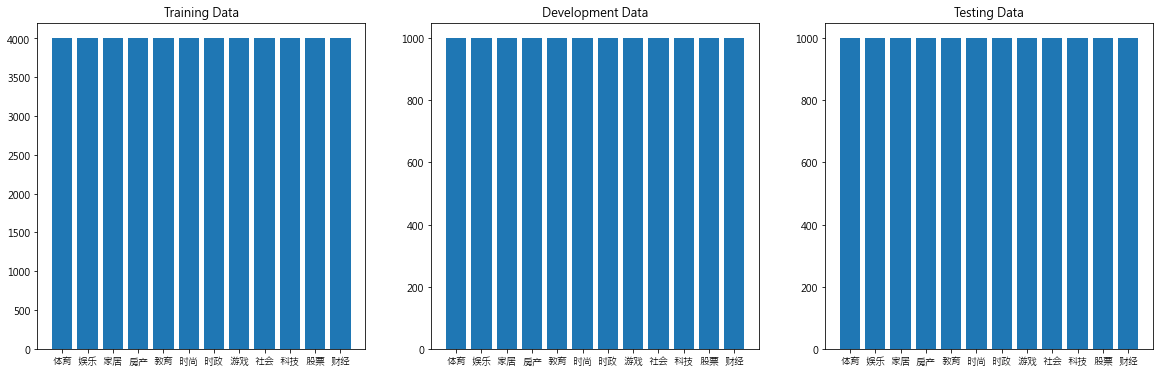

In [5]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))
ax1.bar(train_category_count.index, height = train_category_count['content'])
ax1.set_title('Training Data')
ax2.bar(dev_category_count.index, height = dev_category_count['content'])
ax2.set_title('Development Data')
ax3.bar(test_category_count.index, height = test_category_count['content'])
ax3.set_title('Testing Data')

可以看到 content 中包含了一些特殊字元或標點符號，例如：\u3000、《，由於 BERT 的輸入長度有限(Input size:512 tokens)，因此可預先將不必要的字元去除，避免模型吃進無意義的資訊

In [6]:
df_train['content'][0]

'《海贼王：恶魔之城》热血格斗家展示 \u3000\u3000大型手机网络游戏《海贼王：恶魔之城》以路飞和伙伴之间的故事为主线剧情，引领着玩家体验一个热血的梦幻世界。玩家出生在故事中路飞的故乡，并与他一同成长，直至路飞为了自己的梦想展开远航……玩家此时可以自由选择属于自己的发展方向。\u3000\u3000每个级别达到十级的玩家都可以自由选择职业，沿着所选择的道路一路成长下去，成为世人所瞩目的大师。格斗家致力于武技锻炼，并拥有强大的爆发力，是当仁不让的搏击强者。\u3000\u3000格斗家终生追求就是锻炼武技和身体，对于他们来讲最重要的莫过于在艰辛而危险的训练中让汗水尽情挥洒。他们大多身体敏捷，出手迅速，经常使用难以想象的精巧格斗技能给敌人造成巨大的物理伤害，更有甚者可以把敌人打晕，完全失去抵抗能力。丰富的人体学知识，使他们可以知道每个敌人最致命的弱点。他们拥有良好的体力，善长近攻和灵活的防守。踢腿、翻摔等等看似简单的技能，在格斗家使出来时，却具有强大的杀伤力，往往只须一招一式就可克敌制胜。\u3000\u3000《海贼王》永久免费运营(不含移动网络流量费)，只需安装客户端后立刻可以开始游戏，不需提前注册或定制任何服务。中国 移动用户发送短信内容 ：hz(不区分大小写)到1066666680，即可免费得到《海贼王》客户端下载地址。\u3000\u3000更多游戏信息，请访问Web官方网站www.hzw.92LE.com或Wap官方网站hzw.92LE.com。'

In [7]:
def normalizeString(s):
    s = re.sub(r'[\u3000\xa0《》，。：！”“、…… ]',r'',s)
    s = re.sub(r'https?:\/\/\S*','',s)
    s = re.sub(r'www\S*','',s)
    return s

In [8]:
cleaned_content = []

for text in df_train['content']:
    cleaned_content.append((normalizeString(text)))
    
df_train['content'] = cleaned_content

以下是將不必要的字元去除後的狀態

In [9]:
cleaned_content[0]

'海贼王恶魔之城热血格斗家展示大型手机网络游戏海贼王恶魔之城以路飞和伙伴之间的故事为主线剧情引领着玩家体验一个热血的梦幻世界玩家出生在故事中路飞的故乡并与他一同成长直至路飞为了自己的梦想展开远航玩家此时可以自由选择属于自己的发展方向每个级别达到十级的玩家都可以自由选择职业沿着所选择的道路一路成长下去成为世人所瞩目的大师格斗家致力于武技锻炼并拥有强大的爆发力是当仁不让的搏击强者格斗家终生追求就是锻炼武技和身体对于他们来讲最重要的莫过于在艰辛而危险的训练中让汗水尽情挥洒他们大多身体敏捷出手迅速经常使用难以想象的精巧格斗技能给敌人造成巨大的物理伤害更有甚者可以把敌人打晕完全失去抵抗能力丰富的人体学知识使他们可以知道每个敌人最致命的弱点他们拥有良好的体力善长近攻和灵活的防守踢腿翻摔等等看似简单的技能在格斗家使出来时却具有强大的杀伤力往往只须一招一式就可克敌制胜海贼王永久免费运营(不含移动网络流量费)只需安装客户端后立刻可以开始游戏不需提前注册或定制任何服务中国移动用户发送短信内容hz(不区分大小写)到1066666680即可免费得到海贼王客户端下载地址更多游戏信息请访问Web官方网站'

In [10]:
cleaned_content_dev = []
cleaned_content_test = []

for text in df_dev['content']:
    cleaned_content_dev.append((normalizeString(text)))
    
for text in df_test['content']:
    cleaned_content_test.append((normalizeString(text)))
    
df_dev['content'] = cleaned_content_dev
df_test['content'] = cleaned_content_test

In [11]:
df_train.head()

,label,content
0,游戏,海贼王恶魔之城热血格斗家展示大型手机网络游戏海贼王恶魔之城以路飞和伙伴之间的故事为主线剧情引...
1,游戏,魔力世纪迎春大行动赢取逆天装备杭州流金网络科技有限公司旗下运营的时尚宠物回合经典PK手机网游...
2,游戏,强者天下开天Q传2三公擂台比武电视剧少年英雄方世玉前几集里的擂台争霸可是真好看不仅打斗场面精...
3,游戏,论剑华山之巅笑傲江湖帮会系统揭秘醉卧沙场君莫笑华山论剑几人回WAP游戏巨作笑傲江湖OL的帮派...
4,游戏,三国online二十五日盛大开服三国OL——二零零九年三月二十五日开服在众多玩家朋友的关心下...


在訓練前要先將資料的標籤轉換為數字才能進行訓練，因此設定一個 label_map 將各類別標籤 map 過去

In [12]:
label_map={'游戏':0, '家居':1, '社会':2, '体育':3, 
           '股票':4, '财经':5, '科技':6,  '时政':7, 
           '娱乐':8, '教育':9, '时尚':10, '房产':11,
           '彩票':12, '星座':13}
df_train['label']=df_train['label'].map(label_map)
df_dev['label']=df_dev['label'].map(label_map)
df_test['label']=df_test['label'].map(label_map)

In [13]:
df_train.head()

,label,content
0,0,海贼王恶魔之城热血格斗家展示大型手机网络游戏海贼王恶魔之城以路飞和伙伴之间的故事为主线剧情引...
1,0,魔力世纪迎春大行动赢取逆天装备杭州流金网络科技有限公司旗下运营的时尚宠物回合经典PK手机网游...
2,0,强者天下开天Q传2三公擂台比武电视剧少年英雄方世玉前几集里的擂台争霸可是真好看不仅打斗场面精...
3,0,论剑华山之巅笑傲江湖帮会系统揭秘醉卧沙场君莫笑华山论剑几人回WAP游戏巨作笑傲江湖OL的帮派...
4,0,三国online二十五日盛大开服三国OL——二零零九年三月二十五日开服在众多玩家朋友的关心下...


In [14]:
df_train.to_csv('data/clean_train.csv', index = False)
df_dev.to_csv('data/clean_dev.csv', index = False)
df_test.to_csv('data/clean_test.csv', index = False)

## Modeling

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
import torch
from tqdm.notebook import tqdm
import time


tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-chinanews-chinese')

# 將前面儲存起來的資料讀取進來，這邊使用 load_dataset 會將資料讀進 .cache 中
# 之後獲取會比較快，但若重複太多次會佔用空間，有時需要手動清除 .cache 中的資料

data=load_dataset('csv', data_files={'train':['./clean_train.csv'], 
                                     'valid':['./clean_dev.csv'],
                                     'test':['./clean_test.csv']})

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/880 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Using custom data configuration default-4dd43f67cbde4e15


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/csv/default-4dd43f67cbde4e15/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
def tokenize_function(data:dict):
    return tokenizer(data['content'],padding=True,truncation=True, max_length=512)

tokenized_data = data.map(tokenize_function, batched=True)

  0%|          | 0/49 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

In [17]:
tokenized_data = tokenized_data.remove_columns(['content'])
tokenized_data = tokenized_data.rename_column('label','labels')
tokenized_data.set_format('torch',device='cuda')

tokenized_data['train'].column_names

['attention_mask', 'input_ids', 'labels', 'token_type_ids']

In [18]:
tokenized_data.set_format('torch',device='cuda')

In [19]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 48048
    })
    valid: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 12000
    })
})

In [20]:
from torch.utils.data import DataLoader

BATCHSIZE = 32

train_dataloader = DataLoader(
    tokenized_data["train"], shuffle=True, batch_size=BATCHSIZE)

valid_dataloader = DataLoader(
    tokenized_data["valid"], shuffle=False, batch_size=BATCHSIZE)

In [21]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'attention_mask': torch.Size([32, 512]),
 'input_ids': torch.Size([32, 512]),
 'labels': torch.Size([32]),
 'token_type_ids': torch.Size([32, 512])}

In [22]:
RoBERTa_model = AutoModelForSequenceClassification.from_pretrained('uer/roberta-base-finetuned-chinanews-chinese')

class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.l1 = RoBERTa_model.base_model
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 14)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        pooler_output = self.l1(input_ids, attention_mask, token_type_ids)[1]
        output_2 = self.l2(pooler_output)
        output = self.l3(output_2)
        return output
    
model = RoBERTaClass()
model = torch.nn.DataParallel(model) # 若有多 GPU 可使用 DataParallel() 來加速訓練 
model.to(device)

Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

DataParallel(
  (module): RoBERTaClass(
    (l1): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(21128, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                

## Training

In [23]:
LEARNING_RATE = 3e-05

def loss_fn(output, labels):
    return torch.nn.CrossEntropyLoss()(output, labels)

optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)

In [24]:
def train(epoch):
    model.train() #將 model 設為 training mode
    total_loss = 0
    total = 0
    correct = 0
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device, dtype = torch.long)
        attention_mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        labels = data['labels'].to(device, dtype = torch.long)
        
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = total_loss/total
    train_acc = 100*correct/total
    
    return train_loss, train_acc

In [25]:
def evaluation(val_dataloader):
    model.eval() #將 model 設為 evaluation mode
    total_loss = 0
    total = 0
    correct = 0
    y_pred = []
    y_true = []
    
    print('Evaluating...')
    with torch.no_grad():
        for data in val_dataloader:
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids)
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            
        loss = total_loss/total
        acc = 100.*correct/total    
        
        return loss, acc, y_true, y_pred

In [26]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [27]:
train_losses, train_accus = [], []
val_losses, val_accus = [], []

EPOCH = 10
patience = 7

start = time.time()
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(EPOCH):
    print(f'Epoch {epoch+1} of {EPOCH}')
    
    train_loss, train_acc = train(epoch)
    val_loss, val_acc, _, _ = evaluation(valid_dataloader)
    
    train_losses.append(train_loss)
    train_accus.append(train_acc)
    val_losses.append(val_loss)
    val_accus.append(val_acc)
    
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print('Early stopping')
        break
        
    print(f'Training Loss:{train_loss}, Train Accuracy:{train_acc}')
    print(f'Validation Loss:{val_loss}, Validation Accuracy:{val_acc}')
    
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
Validation loss decreased (inf --> 0.008930).  Saving model ...
Training Loss:0.00738781420066624, Train Accuracy:93.86655011655012
Validation Loss:0.008930051656779445, Validation Accuracy:90.76666666666667
Epoch 2 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
EarlyStopping counter: 1 out of 7
Training Loss:0.002718629926627473, Train Accuracy:97.50457875457876
Validation Loss:0.009316017135691558, Validation Accuracy:92.51666666666667
Epoch 3 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
EarlyStopping counter: 2 out of 7
Training Loss:0.0016771490689484478, Train Accuracy:98.41616716616717
Validation Loss:0.010443370865218942, Validation Accuracy:91.95
Epoch 4 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
Validation loss decreased (0.008930 --> 0.008541).  Saving model ...
Training Loss:0.0011626038226421238, Train Accuracy:98.89901764901765
Validation Loss:0.008540509176167688, Validation Accuracy:93.89166666666667
Epoch 5 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
EarlyStopping counter: 1 out of 7
Training Loss:0.0009227982969178934, Train Accuracy:99.14044289044288
Validation Loss:0.008715928588530611, Validation Accuracy:94.25
Epoch 6 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
EarlyStopping counter: 2 out of 7
Training Loss:0.0007421440349863114, Train Accuracy:99.3048618048618
Validation Loss:0.01199494284857974, Validation Accuracy:92.875
Epoch 7 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
EarlyStopping counter: 3 out of 7
Training Loss:0.0007066227257103468, Train Accuracy:99.32775557775558
Validation Loss:0.014726863787781137, Validation Accuracy:90.66666666666667
Epoch 8 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
EarlyStopping counter: 4 out of 7
Training Loss:0.0005955500601193998, Train Accuracy:99.44014319014319
Validation Loss:0.018081557496282888, Validation Accuracy:89.20833333333333
Epoch 9 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
EarlyStopping counter: 5 out of 7
Training Loss:0.0005074459833657067, Train Accuracy:99.5483682983683
Validation Loss:0.00936846447581441, Validation Accuracy:93.7
Epoch 10 of 10


  0%|          | 0/1502 [00:00<?, ?it/s]

Evaluating...
EarlyStopping counter: 6 out of 7
Training Loss:0.0005475228878176837, Train Accuracy:99.49425574425574
Validation Loss:0.013773086884936978, Validation Accuracy:90.66666666666667
Training time: 166.597 minutes


## Evaluation

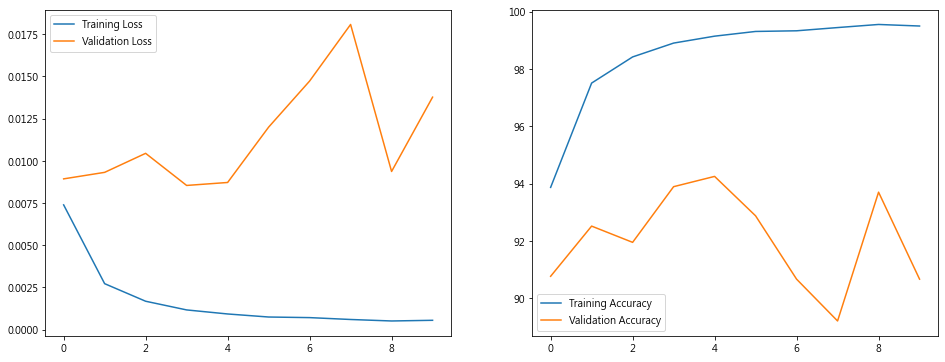

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))

ax1.plot(train_losses, label = 'Training Loss')
ax1.plot(val_losses, label = 'Validation Loss')
ax2.plot(train_accus, label = 'Training Accuracy')
ax2.plot(val_accus, label = 'Validation Accuracy')
ax1.set_label('Epoch')
ax1.set_label('Loss')
ax2.set_label('Epoch')
ax2.set_label('Loss')
ax1.legend()
ax2.legend()

In [29]:
model.load_state_dict(torch.load('checkpoint.pt'))

test_dataloader = DataLoader(
    tokenized_data['test'], shuffle=False, batch_size=BATCHSIZE)

_, test_acc, y_true, y_pred = evaluation(test_dataloader)

print('Evaluation is completed.')
print(f'Testing Accuracy:{test_acc}')

Evaluating...
Evaluation is completed.
Testing Accuracy:94.90833333333333


Text(84.0, 0.5, 'True Label')

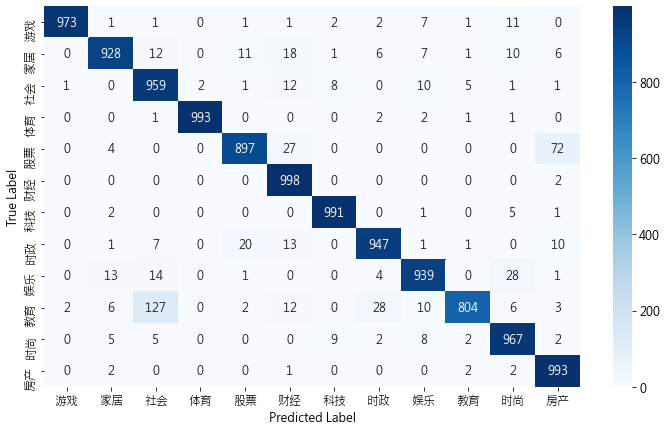

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['font.size'] = '12'

classes = ['游戏', '家居', '社会', '体育', 
           '股票', '财经', '科技',  '时政', 
           '娱乐', '教育', '时尚', '房产']

confusion_matrix = confusion_matrix(y_true, y_pred)
df_confusion_matrix = pd.DataFrame(confusion_matrix, index = classes, columns = classes)

plt.figure(figsize=(12, 7))
sns.heatmap(df_confusion_matrix, annot = True, fmt = 'd', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')